<a href="https://colab.research.google.com/github/InhuKim/Chat-Web/blob/main/subject_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import

In [2]:
import random
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import gc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoModel, AutoTokenizer

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [3]:
gc.collect()
torch.cuda.empty_cache()

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Setting

### Hyperparameter Setting

In [28]:
CFG = {
    'EPOCHS':70,
    'LEARNING_RATE':1e-6,
    'BATCH_SIZE':32,
    'OUT_FEATURES':20,
    'SEED':41,
    'NSPLITS': 5,
    'MODEL': 'klue/roberta-small',
    'MODEL_NAME' : 'RoBERTa-small',
    "save_path" : "/content/drive/MyDrive/Colab_Notebooks/NLP/subject_classification/",
    "NOTE" : 'baseline_lowLR'  # 모델에 변화를 줄때마다 변경사항 표기.
}

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

### Data Load & EDA

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/NLP/data/conversation/training/train_data.csv')

In [8]:
df.columns = ['label', 'text']
df

,label,text
0,주거와 생활,"너희 집 근처에는 병원 있어? 응, 난 엄청 근처에 있어. 나는 차 타고 20분 거..."
1,교통,나는 경유차가 첫차였어 아 노후 경유차였구나 노후 경유차면 운행이 쉽진 않지 서울은...
2,회사/아르바이트,너희 일할 때 mbti 뭐야? 나는 해봤는데 ENTJ야. J들이 꼼꼼하고 계획적이긴...
3,군대,군대는 몇살부터 가는 걸까요? 만 19세 이상부터 가는 걸로 알고 있는데 20세부터...
4,교육,이번에 수학 수행평가 뭔지 알아? 들었었는데 까먹었어. 코사인 법칙 증명하는 거일 ...
...,...,...
69685,연애/결혼,직업군인과 결혼 하는거 어떻게 생각해? 장단점이 분명히 있을거야 아무래도 장점이 커...
69686,스포츠/레저,탁구도 2인경기로 나갔었어요 탁구는 원래 2인 경기가 아닌가요? 탁구도 잘하셨군요 ...
69687,교통,코로나가 끝나도 대중교통 이용시 마스크 계속 써야 할 것같지않아? 응 앞으로 어떤 ...
69688,교육,교육자는 어떤 사람이어야 할까요? 학생에게 올바른 길을 알려주는 사람이요 본보기가 ...


In [9]:
label_data = df.groupby('label')

# blanced data, 상거래 전반 label이 2개로 나뉘어짐.
label_data.count()

,text
label,
가족,3620
건강,3554
게임,3454
계절/날씨,3451
교육,3677
교통,3577
군대,3252
미용,3775
반려동물,3333


In [10]:
# 분리 레이블 합침.
df.loc[df['label'] == '상거래전반', 'label'] = '상거래 전반'

In [11]:
label_data = df.groupby('label')
label_data.count()

,text
label,
가족,3620
건강,3554
게임,3454
계절/날씨,3451
교육,3677
교통,3577
군대,3252
미용,3775
반려동물,3333


In [12]:
text_group = df['text'].apply(len).groupby(df['label'])
print(text_group.min())
print(text_group.max())
print(text_group.mean())

# 128, 256 정도의 sequence 길이로 설정.

label
가족           44
건강           16
게임           87
계절/날씨        76
교육          104
교통           27
군대           11
미용            9
반려동물         62
방송/연예        11
사회이슈         11
상거래 전반      109
스포츠/레저       82
식음료          10
여행            3
연애/결혼        26
영화/만화        93
주거와 생활       93
타 국가 이슈      11
회사/아르바이트    110
Name: text, dtype: int64
label
가족          1305
건강          1799
게임          1457
계절/날씨       1723
교육          1264
교통          1302
군대          1376
미용          1305
반려동물        1385
방송/연예       1493
사회이슈        1599
상거래 전반      1478
스포츠/레저      1242
식음료         2360
여행          1580
연애/결혼       1605
영화/만화       2216
주거와 생활      1790
타 국가 이슈     1452
회사/아르바이트    1427
Name: text, dtype: int64
label
가족          303.810773
건강          300.832020
게임          273.103648
계절/날씨       288.741814
교육          287.459886
교통          289.372659
군대          287.942189
미용          275.298013
반려동물        283.178818
방송/연예       298.492991
사회이슈        307.919255
상거래 전반      306.741

In [13]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.2, random_state=CFG['SEED'])

### Draw graph

In [14]:
def draw_graph(title, loss, valid_loss):
    plt.plot(loss, label="Training Loss")
    plt.plot(valid_loss, label="Validation Loss")
    plt.legend(loc='upper right')
    plt.title(title)
    plt.savefig("/content/drive/MyDrive/Colab_Notebooks/NLP/subject_classification/chart/" + title + ".png")
    plt.show()

# Model Build

### Label Encoding

In [15]:
label_pre = preprocessing.LabelEncoder()
train['label'] = label_pre.fit_transform(train['label'].values)
val['label'] = label_pre.fit_transform(val['label'].values)

In [16]:
train_label = train['label'].values
val_label = val['label'].values

### CustomDataset

In [17]:
# tokenization, 
def convert_examples_to_features(examples, max_seq_len):
    input_ids, attention_masks, token_type_ids = [], [], []
    tokenizer = AutoTokenizer.from_pretrained(CFG['MODEL'])

    for text in examples['text']:
        inputs = tokenizer.encode_plus(text, return_tensors='pt', padding='max_length', max_length= max_seq_len, truncation= True)
        input_ids.append(inputs['input_ids'][0])
        attention_masks.append(inputs['attention_mask'][0])

    return input_ids, attention_masks

In [18]:
ids, masks = convert_examples_to_features(train, 128)
val_ids, val_masks = convert_examples_to_features(val, 128)

In [19]:
class CustomDataset(Dataset):
    def __init__(self, ids, masks, label):
        self.ids = ids
        self.masks = masks
        self.label = label

    def __getitem__(self, index):

        if self.label is not None:
            return self.ids[index], self.masks[index], self.label[index]

        else:
            return self.ids[index], self.masks[index]

    def __len__(self):
        return len(self.ids)

In [20]:
train_dataset = CustomDataset(ids, masks, train_label)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_ids, val_masks, val_label)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

In [21]:
for id, mask, label in tqdm(train_loader):
    print(id)
    print(mask)
    print(label)
    break

  0%|          | 0/1743 [00:00<?, ?it/s]

tensor([[    0,  5565,  2052,  ...,     1,     1,     1],
        [    0,   684, 29350,  ...,     1,     1,     1],
        [    0,    14,    14,  ...,  2284, 24533,     2],
        ...,
        [    0,   743,  2203,  ...,     1,     1,     1],
        [    0,  5266,  2119,  ...,  2075,  2168,     2],
        [    0,   809,  2031,  ...,     1,     1,     1]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([ 6,  4,  0, 11, 13, 13,  0, 14,  1,  9, 14, 14,  9, 14,  0,  0, 15, 12,
        13,  5, 10, 11, 10, 12,  9, 12, 19,  7,  7,  0,  4, 10])


### Model

In [21]:
class Roberta(nn.Module):

    def __init__(self, dropout=0.5):
        super(Roberta, self).__init__()
        
        self.bert = AutoModel.from_pretrained(CFG['MODEL'])

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=768, out_features=384),
            nn.LeakyReLU(),
            nn.Linear(in_features=384, out_features=CFG['OUT_FEATURES']),
        )

    def forward(self, ids, masks):

        _, x = self.bert(input_ids= ids, attention_mask=masks,return_dict=False)
        
        output = self.classifier(x)
        
        return output

In [23]:
model = Roberta().to(device)

Downloading:   0%|          | 0.00/545 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-small were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it f

In [24]:
for id, mask, label in tqdm(train_loader):
    id = id.to(device)
    mask = mask.to(device)
    a = model(id, mask)
    print(a)
    print(label)
    break

  0%|          | 0/1743 [00:00<?, ?it/s]

tensor([[-6.4283e-02, -7.9897e-03,  1.1330e-02,  3.2348e-02, -5.7603e-02,
          4.4730e-02, -6.0066e-02, -8.4787e-02, -6.2614e-02, -1.1951e-01,
          5.7955e-02,  3.4347e-02, -9.2529e-03,  1.0845e-01, -4.6979e-02,
         -5.2493e-02,  2.5808e-02, -1.4912e-02, -8.3374e-03,  6.2771e-02],
        [ 3.2809e-03,  6.2047e-02, -1.8329e-02,  4.1527e-02, -3.2163e-02,
         -5.0075e-02,  5.4394e-02, -7.6832e-02, -7.0034e-02, -1.1045e-01,
          4.8887e-02,  1.0783e-02, -1.6684e-01,  1.4643e-01, -4.8908e-02,
         -4.5678e-03,  1.7390e-01, -8.0376e-02,  3.8820e-02,  6.7439e-02],
        [-6.0122e-02,  7.7006e-02, -2.9595e-02,  1.0274e-01,  2.5265e-02,
         -7.7843e-02,  2.1186e-02, -6.0027e-02, -8.1726e-02, -1.0237e-01,
          1.7991e-02, -2.8542e-02, -6.4751e-02,  1.8453e-01, -1.8499e-02,
         -4.5401e-02,  2.7006e-02, -6.7980e-02, -6.3254e-02,  5.0708e-02],
        [-5.8835e-02,  5.1583e-02,  4.9388e-02,  2.5768e-03, -1.6876e-02,
         -5.7443e-02,  7.6340e-02, 

# Train

In [25]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    
    best_loss = 999999
    best_model = None

    patience = 3
    earlystopping = 0

    loss_plot = []
    val_loss_plot = []


    print("--------------------------------------------")
    print("model : {}".format(CFG['MODEL']))
    print("learning rate : {}".format(CFG['LEARNING_RATE']))
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for ids, masks, labels in tqdm(train_loader):
            
            id = ids.to(device)
            mask = masks.to(device)
            label = labels.to(device)
            
            optimizer.zero_grad()
            
            logit = model(ids = id, masks = mask)
            
            loss = criterion(logit, label)

            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss, val_f1 = validation(model, val_loader, criterion, device)

        # draw graph
        loss_plot.append(np.mean(train_loss))
        val_loss_plot.append(val_loss)

        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]] F1 - Score : [{val_f1:.5f}]')

        
        if scheduler is not None:
            scheduler.step(val_loss)
            
        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            torch.save(model.state_dict(), CFG['save_path'] + 'checkpoint/' + '{}_{}_{}_example.pth'.format(CFG['MODEL_NAME'], 'AdamW', CFG['NOTE']))
            print('------------------ Model Saved ------------------')
            earlystopping = 0

        elif best_loss < val_loss:
            earlystopping += 1
            if earlystopping == patience:
                print("------------stop----------------")
                title = "{}_{}_epoch:{} loss, note: {}".format(CFG['MODEL_NAME'], 'AdamW', epoch, CFG['NOTE'])
                draw_graph(title, loss_plot, val_loss_plot)
                break
                
        if epoch == CFG['EPOCHS']:
            title = "{}_{}_epoch:{} loss, note{}".format(CFG['MODEL_NAME'], 'AdamW', epoch, CFG['NOTE'])
            draw_graph(title, loss_plot, val_loss_plot)

    return best_model

In [23]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    val_preds = []
    val_labels = []
    

    with torch.no_grad():
        for ids, masks, labels in tqdm(val_loader):
    
            id = ids.to(device)
            mask = masks.to(device)
            label = labels.to(device)

            logit = model(ids = id, masks = mask)
            

            loss = criterion(logit, label)

            val_loss.append(loss.item())
            
            val_preds += logit.argmax(1).detach().cpu().numpy().tolist()
            val_labels += label.detach().cpu().numpy().tolist()
    
    f1 = f1_score(val_labels, val_preds, average='weighted')
    
    return np.mean(val_loss), f1

# Run

Some weights of the model checkpoint at klue/roberta-small were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it f

--------------------------------------------
model : klue/roberta-small
learning rate : 1e-06


  0%|          | 0/1743 [00:00<?, ?it/s]

  0%|          | 0/436 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.17406] Val Loss : [0.35087]] 유형 F1 : [0.90352]
------------------ Model Saved ------------------


  0%|          | 0/1743 [00:00<?, ?it/s]

  0%|          | 0/436 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.15978] Val Loss : [0.35681]] 유형 F1 : [0.90293]


  0%|          | 0/1743 [00:00<?, ?it/s]

  0%|          | 0/436 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.14902] Val Loss : [0.36338]] 유형 F1 : [0.90243]


  0%|          | 0/1743 [00:00<?, ?it/s]

  0%|          | 0/436 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.14135] Val Loss : [0.36964]] 유형 F1 : [0.90235]
Epoch 00004: reducing learning rate of group 0 to 5.0000e-07.
------------stop----------------


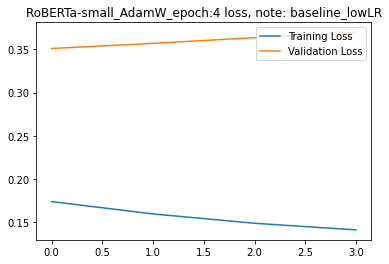

In [29]:
model = Roberta().to(device)
save_model = torch.load("/content/drive/MyDrive/Colab_Notebooks/NLP/subject_classification/checkpoint/RoBERTa-small_AdamW_baseline_example.pth", map_location=device)
model.load_state_dict(save_model)
model.eval()
optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

# Inference